In [ ]:
#@title Net structure

import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import cProfile as profile
import string



class NetStructure:
    def __init__(self, input_dim, output_dim):
        self.input_dim  = input_dim
        self.n_hidden   = 0
        self.hidden_dim = []
        self.output_dim = output_dim
        self.activation = []

    def add_hidden(self, hidden_dim, activation = 'linear'):
        self.n_hidden += 1
        self.hidden_dim.append(hidden_dim)
        self.activation.append(activation)

    def get_input_dim(self):
        return self.input_dim

    def get_output_dim(self):
        return self.output_dim

    def get_num_hidden(self):
        return self.n_hidden

    def get_hidden_dim(self, index):
        return self.hidden_dim[index]

    def get_activation(self, index):
        return self.activation[index]

    def print(self):
        print("----------------------")
        print("    Input dim:", self.input_dim)
        for i in range(self.n_hidden):
            print(" Hidden", i+1, "dim:", self.hidden_dim[i], "- activation:", self.activation[i])
        print("   Output dim:", self.output_dim)
        print("----------------------")


In [ ]:
#@title Meta

class Meta:
    def __init__(self, net_structure):
        self.net_structure  = net_structure

        # definisco il modello sulla base della struttura che gli ho passato
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(net_structure.get_hidden_dim(0), activation=net_structure.get_activation(0), input_dim=net_structure.get_input_dim()))
        for i in range(1, net_structure.get_num_hidden()):
            self.model.add(tf.keras.layers.Dense(net_structure.get_hidden_dim(i), activation=net_structure.get_activation(i)))
        self.model.add(tf.keras.layers.Dense(net_structure.get_output_dim()))

        # salvo il numero di parametri del modello
        self.num_parameters = self.model.count_params()

        # dominio di default per i latent points
        self.domain = [-1, 1]

        self.output_dim = net_structure.get_output_dim()

    def get_model(self):
        return self.model

    def get_output_dim(self):
        return self.output_dim

    def set_num_iterations(self, num_iterations):
        self.num_iterations = num_iterations

    def set_population_size(self, population_size):
        self.population_size = population_size

    def set_latent_points_domain(self, domain):
        self.domain = domain

    def is_in_domain(self, x):
        if (x < self.domain[0] or x > self.domain[1]):
            return False
        return True

    def generate_latent_points(self, n_samples):
        self.latent_points = np.random.uniform(self.domain[0], self.domain[1], (n_samples, self.net_structure.get_input_dim()))

    def update_model_with_parameters(self, opt_par):
        nl = len(self.model.layers)
        wbindex = 0
        for p in range(0, nl):
          W = opt_par[wbindex:(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1])]
          b = opt_par[(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]):(wbindex + self.model.layers[p].count_params())]
          self.model.layers[p].set_weights([W.reshape(self.model.layers[p].input.shape[1], self.model.layers[p].output.shape[1]), b])
          wbindex = (wbindex + self.model.layers[p].count_params())

    def objective_function(self, x = None):
        if (x == None):
            x = self.latent_points
        somma1 = 0
        #somma2 = 0
        somma3 = 0
        somma4 = 0
        result = []

        y_pred = self.model.predict(x, verbose = 0)

        y_pred = y_pred.tolist()

        y_pred_string = []
        i_pred_string = str()
        for i in y_pred:
            for x in range(len(i)):
                # penalizzo i valori che sono superiori a 3 (che corrisponde con il valore massimo accettabile)
                if i[x] >= 4 or i[x] < 0:
                    somma1 += 1

                # penalizzo se i valori a, b, c non sono in ordine crescente
                #iterator = iter(i[1:])
                #if i[x] != (next(iterator) + 1) or i[x] != next(iterator):
                    #somma2 += 1
            # penalizzo la generazione di valori non accettabili per i primi due elementi
            if i[0] == 0 or i[1] == 0 or i[0] > 2 or i[1] > 2:
                somma3 += 1

            # penalizzo la generazione di sequenze identiche trasformando ogni vettore di y_pred in una stringa e poi confrontando tra di loro le stringhe
            i_string = map(str, i)
            i_pred_string = ''.join(i_string)
            y_pred_string.append(i_pred_string)


        [result.append(x) for x in y_pred_string if x not in result]
        #y_pred_string = set(y_pred_string)
        somma4 += (len(y_pred) - len(result))

        #print("somma1 = ", somma1)
        #print("somma2 = ", somma2)
        #print("somma3 = ", somma3)
        print("somma4 = ", somma4)

        return somma1 + somma3 + somma4

In [ ]:
#@title PSO


########################################################################
class PSO(Meta):
    def __init__(self, net_structure):
        super().__init__(net_structure)
        self.w  = 0.3 # inertia_param
        self.c1 = 1.5 # cognitive_param
        self.c2 = 1.5 # social_param

    def set_options(self, inertia_param = 0.3,
                    cognitive_param = 1.5,
                    social_param = 1.5):
        self.w  = inertia_param
        self.c1 = cognitive_param
        self.c2 = social_param

    def set_max_v(self, max_v):
        self.max_v = max_v

    def set_max_x(self, max_x):
        self.max_x = max_x

    def update_velocity(self, position, velocity, best_position, global_best_position):
        inertia = self.w * velocity
        cognitive_component = self.c1 * np.random.rand(1, len(position)) * (best_position - position)
        social_component = self.c2 * np.random.rand(1, len(position)) * (global_best_position - position)
        new_velocity = inertia + cognitive_component + social_component
        return new_velocity

    def optimize(self):
        # ATTENZIONE: è necessario aver generato i latent points in precedenza
        particles  = np.random.uniform(low=0, high=self.max_x, size=(self.population_size, self.num_parameters))
        velocities = np.random.uniform(low=-self.max_v, high=self.max_v, size=(self.population_size, self.num_parameters))
        best_positions = np.copy(particles)
        best_scores = np.array([self.num_parameters] * self.population_size)
        global_best_position = None
        global_best_score = 1e10
        nl = len(self.model.layers)

        for iteration in range(self.num_iterations):
            tic_global = time.perf_counter()

            for i in range(self.population_size):
                particle = particles[i,]

                wbindex = 0

                for p in range(0, nl):
                  W = particle[wbindex:(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1])]
                  b = particle[(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]):(wbindex + self.model.layers[p].count_params())]
                  self.model.layers[p].set_weights([W.reshape(self.model.layers[p].input.shape[1], self.model.layers[p].output.shape[1]), b])
                  wbindex = (wbindex + self.model.layers[p].count_params())

                fitness = self.objective_function()

                #print(fitness)

                if  fitness < best_scores[i]:
                    best_scores[i] = fitness
                    best_positions[i] = np.copy(particles[i])

                if  fitness < global_best_score:
                    global_best_score = fitness
                    global_best_position = np.copy(particles[i])

                velocities[i] = self.update_velocity(particles[i], velocities[i], best_positions[i], global_best_position)
                particles[i] += velocities[i]

            # mi assicuro che le velocità e posizioni siano nei range
            velocities = np.minimum(velocities,  self.max_v)
            velocities = np.maximum(velocities, -self.max_v)
            particles  = np.minimum(particles,  self.max_x)
            particles  = np.maximum(particles, -self.max_x)

            toc_global = time.perf_counter()
            print("Iteration #%d - Objective function value: %5.2f - time: %0.3f" % (iteration, global_best_score, toc_global - tic_global))

            # se l'errore fa a zero mi fermo
            if (global_best_score == 0):
                break

        return global_best_position

    def predict(self, x = None):
        if (x == None):
            x = self.latent_points
        return self.model.predict(x)


########################################################################
########################################################################
########################################################################

## Code for generating a couple of numbers (a,b) where a > b

net = NetStructure(input_dim=2, output_dim=5)
net.add_hidden(hidden_dim=5)

met = PSO(net)
met.set_num_iterations(50)
met.set_population_size(50)
met.set_max_v(0.3)
met.set_max_x(1.5)

sample_size = 1000
domain = [0, 1]

# TRAIN
met.set_latent_points_domain(domain)               # definisco il dominio per i latent points
met.generate_latent_points(sample_size)            # genera i latent points su cui fare il training
optimized_params = met.optimize()                  # trova i parametri migliori della rete
met.update_model_with_parameters(optimized_params) # setta nella rete i parametri migliori

# TEST
met.generate_latent_points(sample_size) # genera nuovi latent points su cui fare la predizione
y_test = met.predict()                  # fa la predizione sui latent points
l_test = met.objective_function()       # calcola la loss sui latent points

#print("\nObjective function value: (test data): " , l_test)
print(np.floor(y_test[0,:]))

somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0
somma4 =  0


KeyboardInterrupt: 

In [ ]:
print("\nAccuracy (test data): " , (sample_size - l_test)/sample_size * 100, "%")
print(np.floor(y_test[:20,:]))


Accuracy (test data):  67.9 %
[[1. 0. 2. 2. 2.]
 [2. 2. 3. 3. 3.]
 [2. 2. 4. 3. 4.]
 [1. 1. 2. 2. 2.]
 [1. 1. 3. 2. 3.]
 [0. 0. 2. 1. 1.]
 [0. 0. 2. 1. 1.]
 [1. 1. 3. 2. 3.]
 [1. 1. 3. 2. 2.]
 [1. 1. 3. 2. 2.]
 [1. 1. 2. 2. 2.]
 [1. 1. 2. 2. 2.]
 [1. 0. 2. 2. 2.]
 [0. 0. 1. 1. 1.]
 [1. 1. 3. 2. 3.]
 [1. 1. 2. 2. 2.]
 [0. 0. 2. 1. 1.]
 [0. 0. 1. 1. 1.]
 [1. 1. 3. 2. 3.]
 [1. 1. 3. 2. 3.]]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-16-d0d7c1922cb6>:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


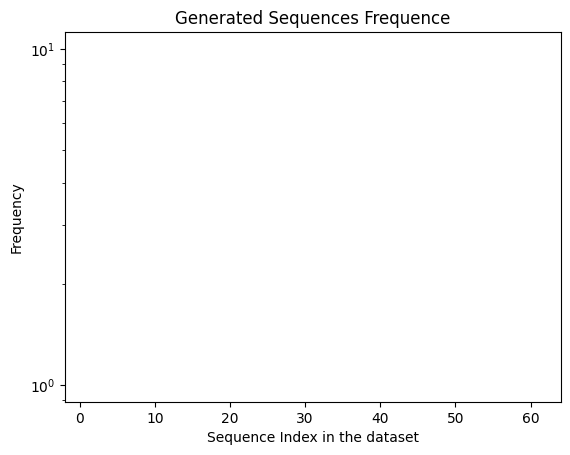

In [ ]:
########################################################################
class Sequence:
    def __init__(self, data: list) -> None:
        data = [int(x) for x in data]
        self.data = data

    def __eq__(self, rhs) -> bool:
        return self.data == rhs.data

# Mount Google Drive if your file is saved there
from google.colab import drive
drive.mount('/content/drive')

# File path to your text file
file_path = "/content/drive/MyDrive/Colab Notebooks/Copia di v_operations_2.txt"

# Read the text file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the text into a vector of Sequence
vect_seq = []
for line in lines:
    row = [int(x) for x in line.split()]
    seq = Sequence(row)
    vect_seq.append(seq)

plt.figure()
freq = []
for i in range(0, len(y_test)):
  seq = Sequence(y_test[i,:])
  if seq in vect_seq:
    freq.append(vect_seq.index(seq))
plt.hist(freq, bins=100, color='blue', range=[1,len(vect_seq)+1])
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Sequence Index in the dataset")
plt.title('Generated Sequences Frequence')
plt.show(block=False)